In [47]:

import monai
import pydicom
from monai.config import print_config
from monai.data import Dataset, DataLoader

from monai.utils import first
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    AsChannelLastd,
    SqueezeDimd,
    AddChanneld,
    NormalizeIntensityd,
    Resized,
)
#from monai.handlers.utils import from_engine
from monai.config import print_config
import torch
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import numpy as np

print_config()



MONAI version: 0.8.1
Numpy version: 1.19.5
Pytorch version: 1.10.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.13.1
Pillow version: 8.4.0
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2+cu102
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.4.5
pandas version: 0.23.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [31]:

# Parent directory where "train" and "test" folders are located
parent_directory = '//mnt/c/Users/ahmad/OneDrive - Delft University of Technology/studi/TUD/Internship/Clean_data/'

# Function to extract label from the folder path
def extract_label(folder_path):
    # Split the folder path and take the last two elements as the label
    components = folder_path.split(os.path.sep)
    label = os.path.join(components[-1])
    return label

# Create a list of dictionaries with keys "path" and "label"
train_list, test_list = [], []

# Iterate through "train" and "test" folder
for split in ["Train Sample", "Test Sample"]:
    split_folder = os.path.join(parent_directory, split)
    for root, _, files in os.walk(split_folder):
        if files:
            dicom_files_path = natsorted([os.path.join(root, file) for file in files if file.lower().endswith('.dcm')])
            # Now instead of finding the label for all these files, lets do it just for the first index, Note I am not using the extract_label function you made
            label = os.path.basename(os.path.normpath(root))
            if split == "Train Sample":
                train_list.append({"image": dicom_files_path, "label": label})
            elif split == "Test Sample":
                test_list.append({"image": dicom_files_path, "label": label})      

In [32]:
# Define a custom Dataset class to load DICOM files and extract data
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__(data, transform)

    def __getitem__(self, index):
        dicom_files_path = self.data[index]["image"]
        label = self.data[index]["label"]

        # Extract dicom info from first entry
        dicom_data = pydicom.dcmread(dicom_files_path[0])
        
        # DICOM header attributes
        patient_ID = str(dicom_data.PatientName)
        if hasattr(dicom_data, 'RepetitionTime'):
            repetition_time = int(float(dicom_data.RepetitionTime))
            
        if hasattr(dicom_data, 'EchoTime'):
            echo_time = int(float(dicom_data.EchoTime))
        
        if hasattr(dicom_data, 'MagneticFieldStrength'):
            magnetic_strength = str(dicom_data.MagneticFieldStrength)

        return {"image": dicom_files_path, "label": label, "patient_name": patient_ID, "metadata": {"repetition_time": repetition_time, "echo_time": echo_time, "magnetic_strength": magnetic_strength, "number_slices": len(dicom_files_path)}}

# Create a MONAI dataset
train = CustomDataset(data=train_list)
test = CustomDataset(data=test_list)

In [33]:
train_dataset = monai.data.Dataset(train, transform=None)

print(f"Length of dataset is {len(train_dataset)}")

test_dataset = monai.data.Dataset(test, transform=None)

print(f"Length of dataset is {len(test_dataset)}")


Length of dataset is 43
Length of dataset is 15


In [34]:
number_slices_values = [item['metadata']['number_slices'] for item in test_dataset]
slice_median = int(np.median(number_slices_values))
print(slice_median)

25


In [38]:

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        SqueezeDimd(keys=["image"], dim=-1), 
        AsChannelLastd(keys=["image"], channel_dim=0), 
        AddChanneld(keys=["image"]),
    ]
)

trial_transform = Compose(
    [
        LoadImaged(keys=["image"]),
        SqueezeDimd(keys=["image"], dim=-1), 
        AsChannelLastd(keys=["image"], channel_dim=0), 
        AddChanneld(keys=["image"]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

resize_transform = Compose(
    [
        LoadImaged(keys=["image"]),
        SqueezeDimd(keys=["image"], dim=-1), 
        AsChannelLastd(keys=["image"], channel_dim=0), 
        AddChanneld(keys=["image"]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True), 
        Resized(keys="image", spatial_size=(512,512,slice_median), size_mode='all', mode='trilinear', align_corners=True),  
    ]
)

image shape: torch.Size([1, 1, 256, 256, 18])


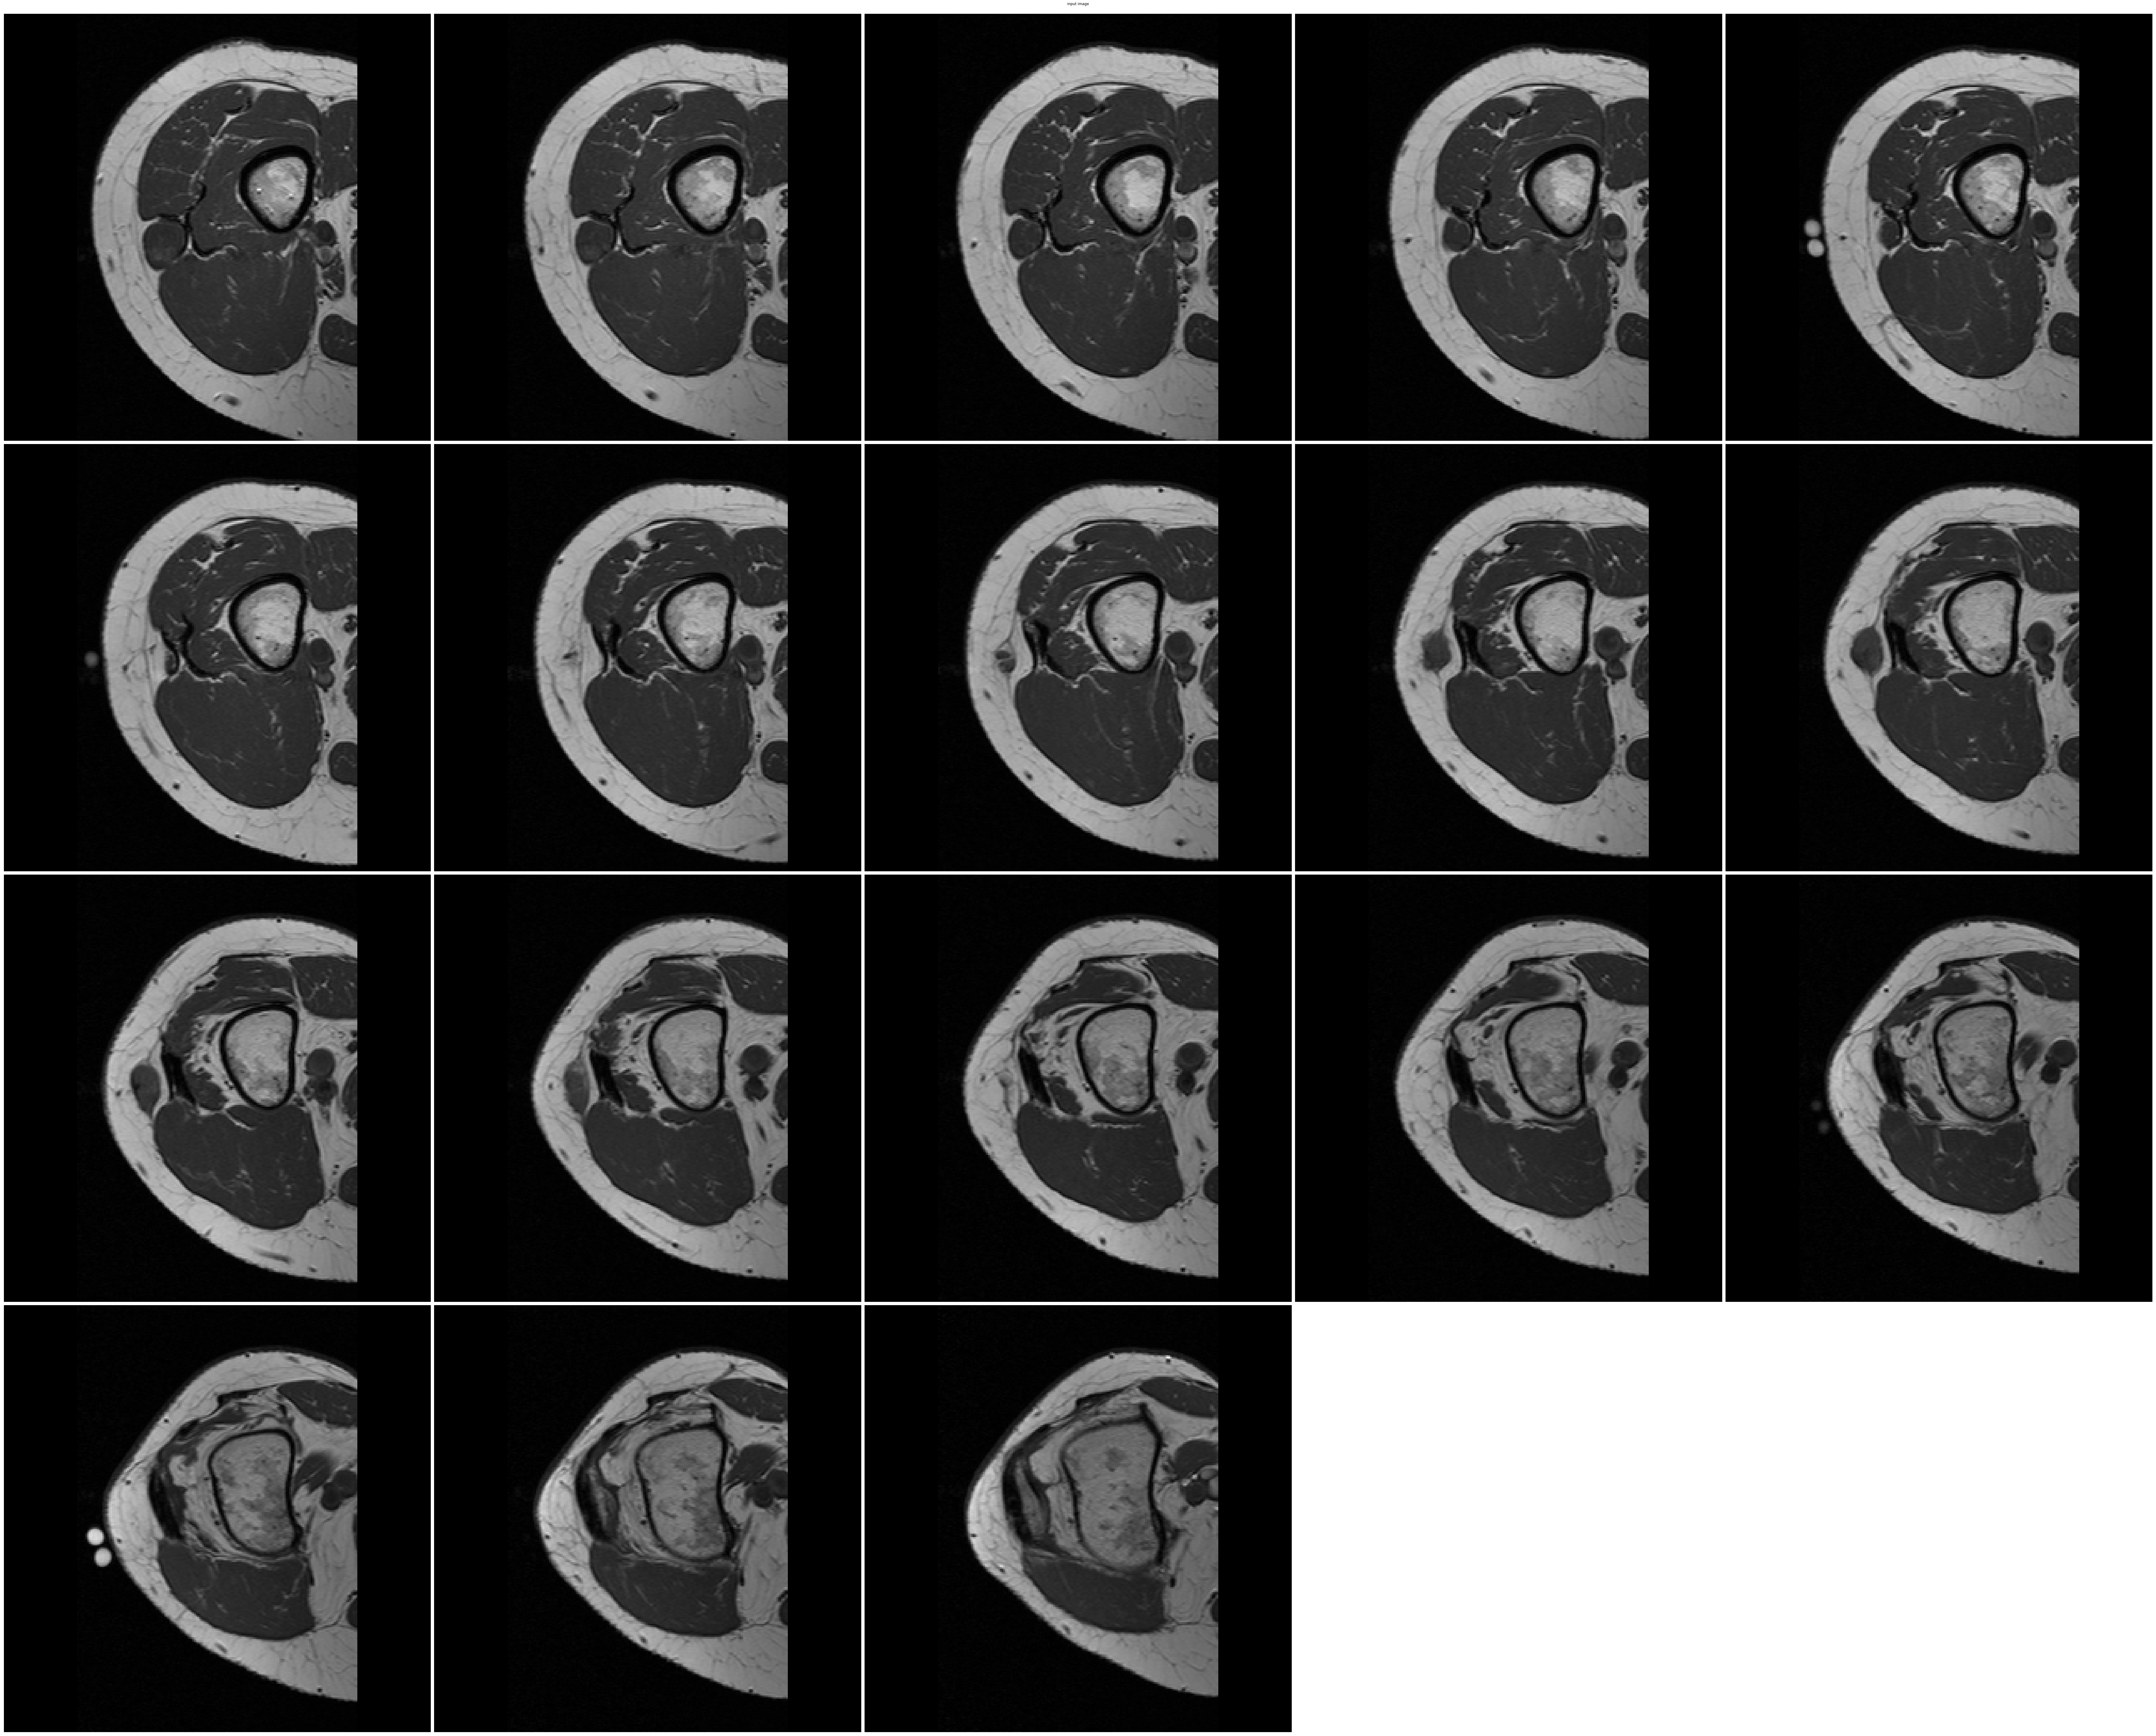

(<Figure size 7200x7200 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

In [39]:
from monai.visualize import matshow3d
check_ds = Dataset(data=test_dataset, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image = (check_data["image"])
print(f"image shape: {image.shape}")

matshow3d(
    volume=check_data["image"],
    fig=None,
    title="input image",
    figsize=(100, 100),
    frame_dim=-1,
    show=True,
    cmap="gray",
)

image shape: torch.Size([1, 1, 256, 256, 18])


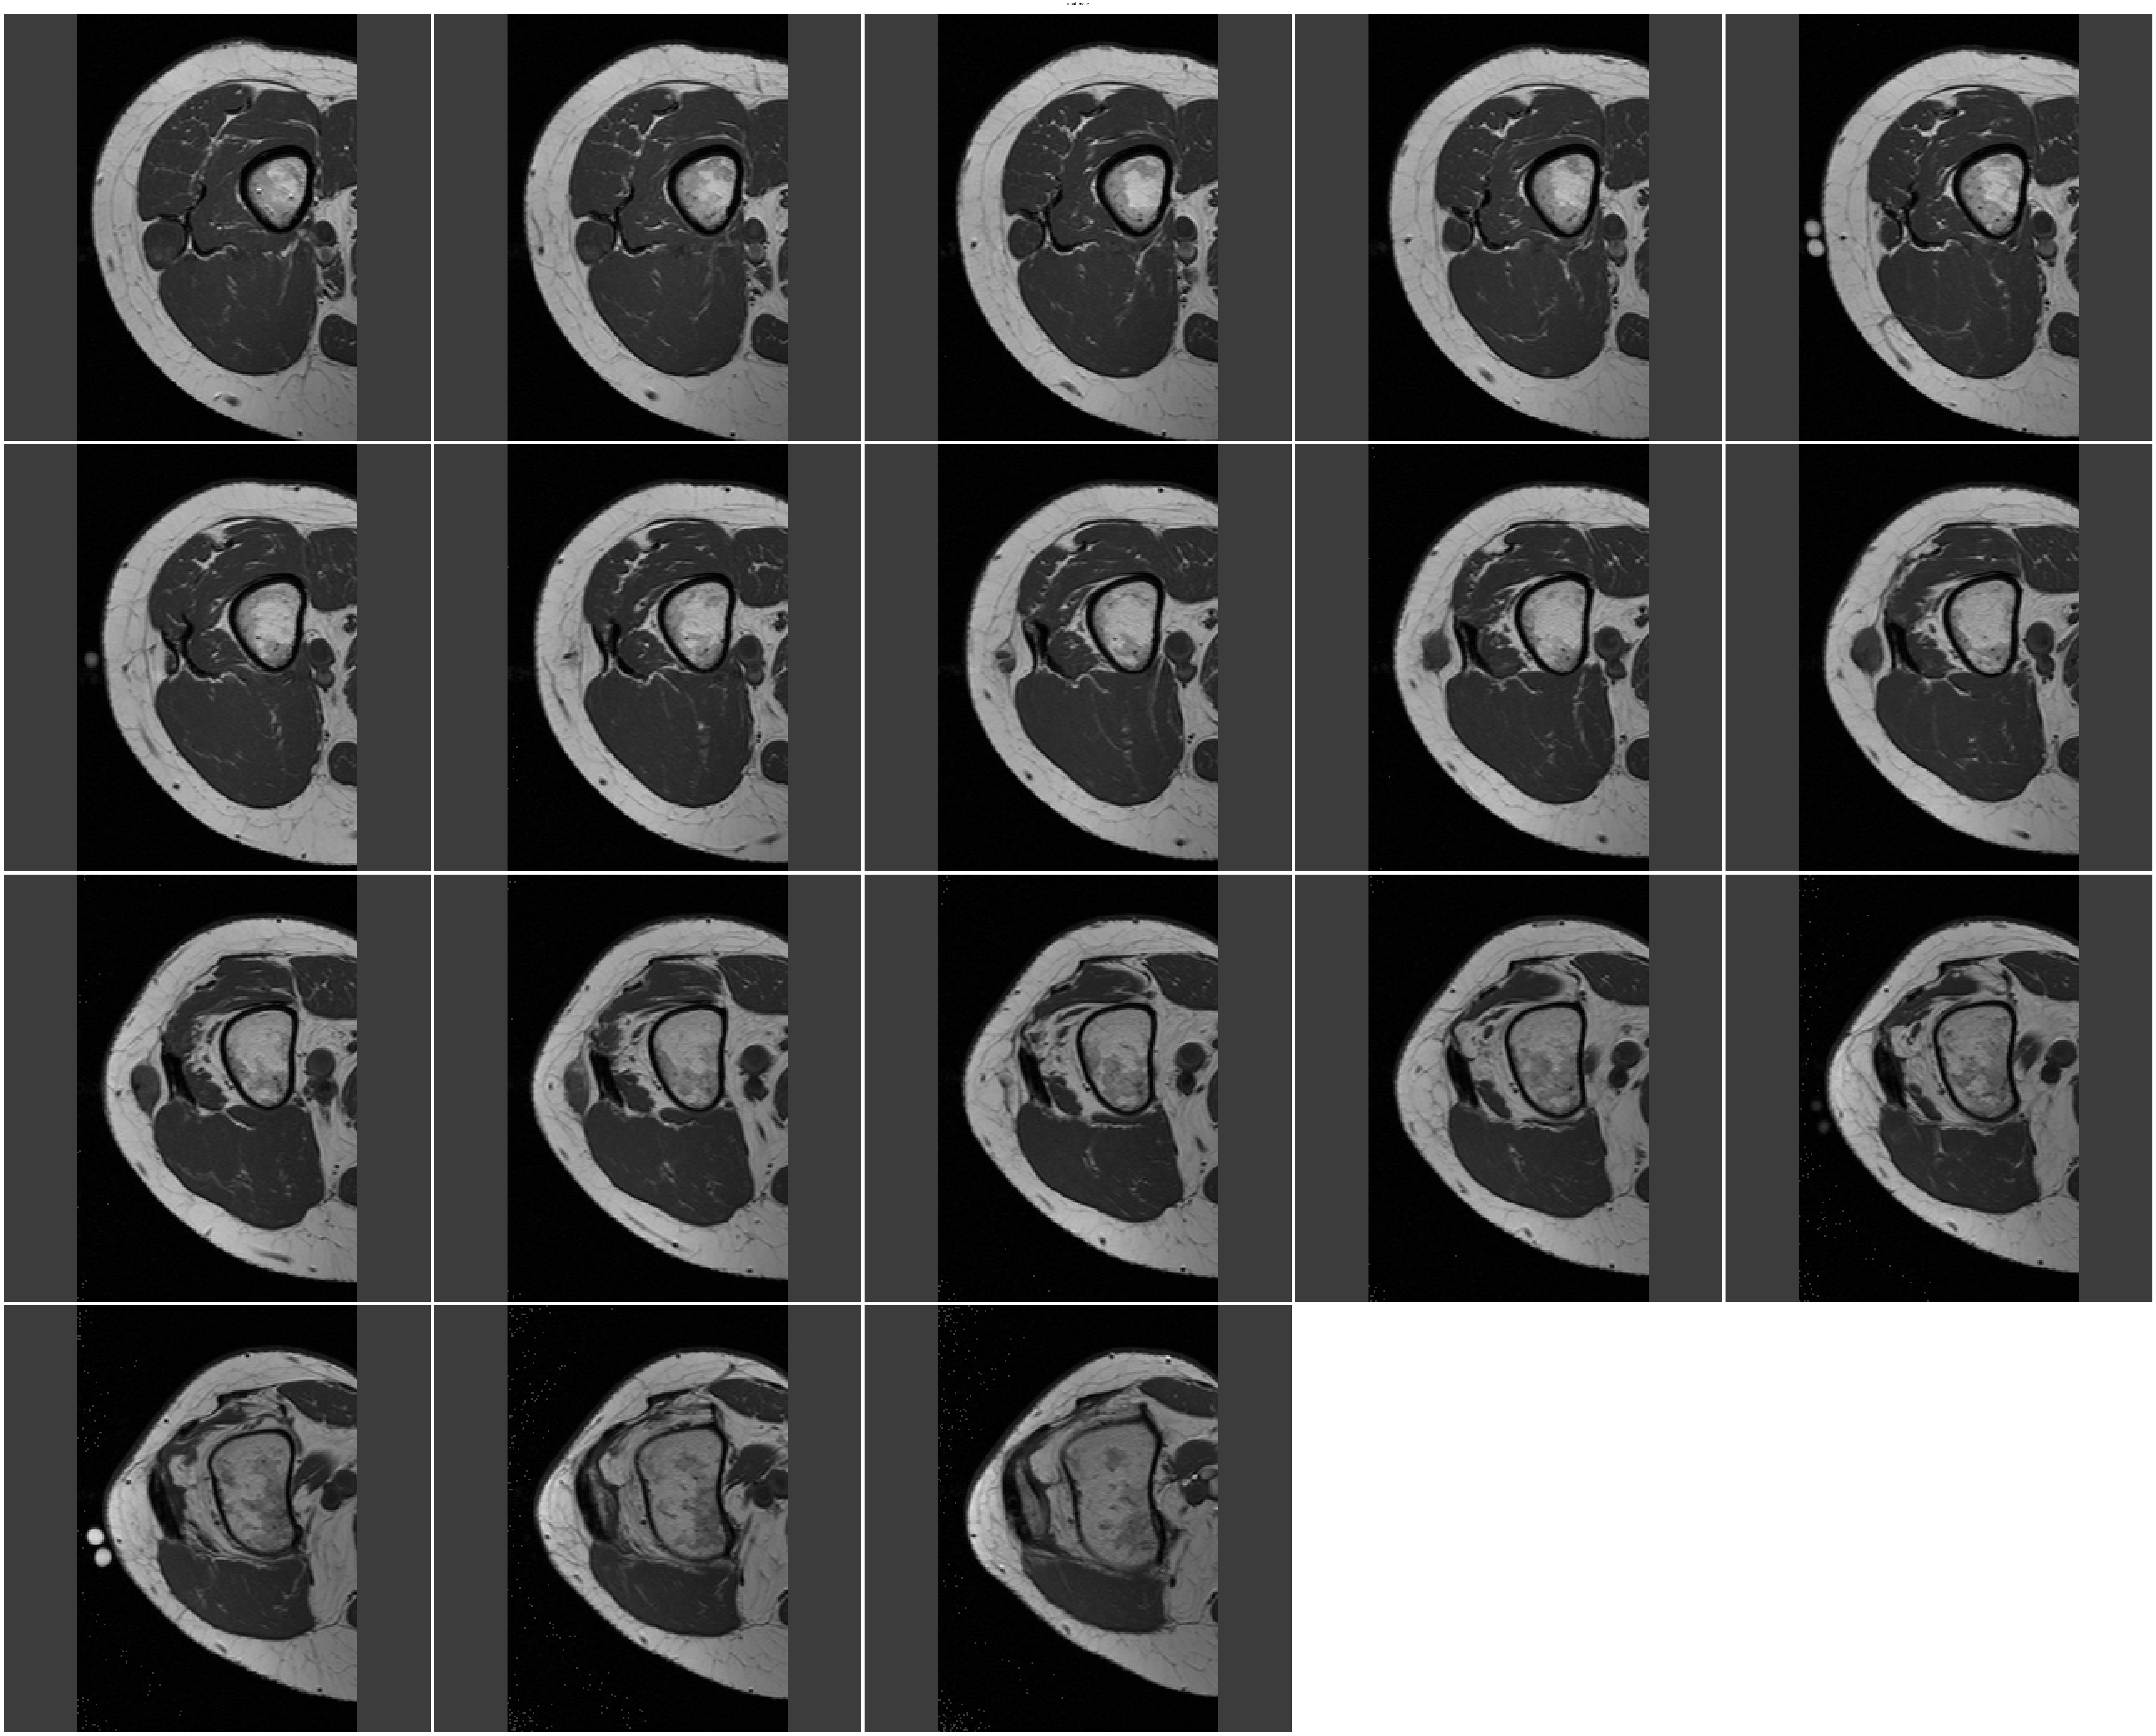

(<Figure size 7200x7200 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

In [40]:
from monai.visualize import matshow3d
check_ds_trial = Dataset(data=test_dataset, transform=trial_transform)
check_loader_trial = DataLoader(check_ds_trial, batch_size=1)
check_data_trial = first(check_loader_trial)
image_trial = (check_data_trial["image"])
print(f"image shape: {image.shape}")

matshow3d(
    volume=check_data_trial["image"],
    fig=None,
    title="input image",
    figsize=(100, 100),
    frame_dim=-1,
    show=True,
    cmap="gray",
)

In [73]:
print(image.shape)
print_image = image[0,0,:,:,0]
print(print_image.shape)

torch.Size([1, 1, 256, 256, 18])
torch.Size([256, 256])


torch.Size([256, 256])


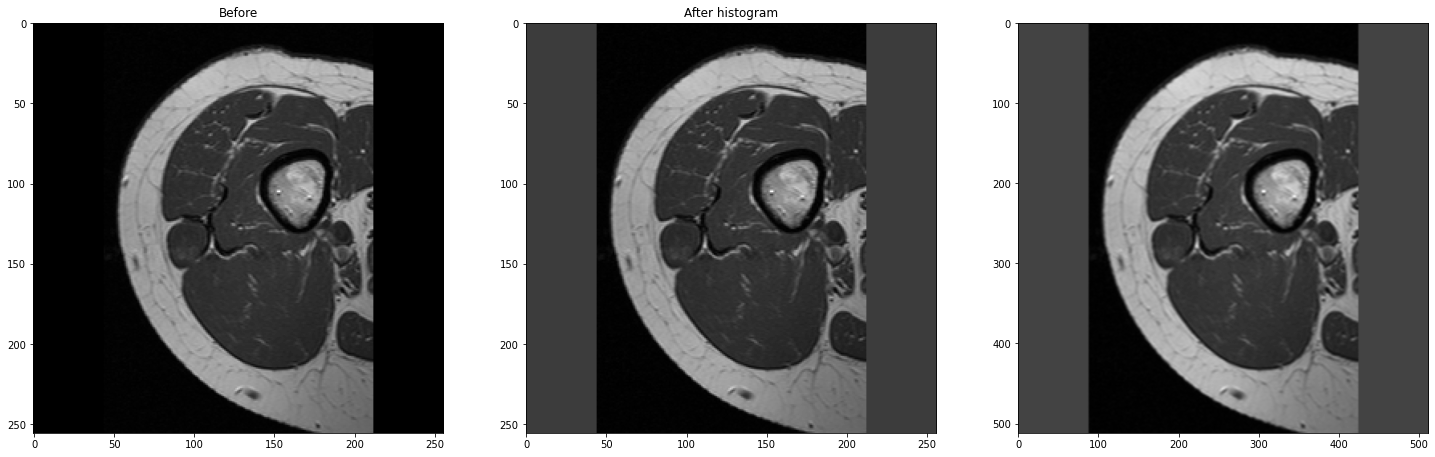

In [80]:
print_image = image[0,0,:,:,0]
print_image_trial = image_trial[0,0,:,:,0]
print_image_resize = image_resize[0,0,:,:,0]

print(print_image.shape)
fig, axes = plt.subplots(1, 3, figsize=(25, 25))
axes[0].imshow(print_image, cmap="gray") 
axes[1].imshow(print_image_trial, cmap="gray") 
axes[2].imshow(print_image_resize, cmap="gray") 
axes[0].set_title('Before'), axes[1].set_title('After histogram'), axes[1].set_title('After Resize')
plt.show()

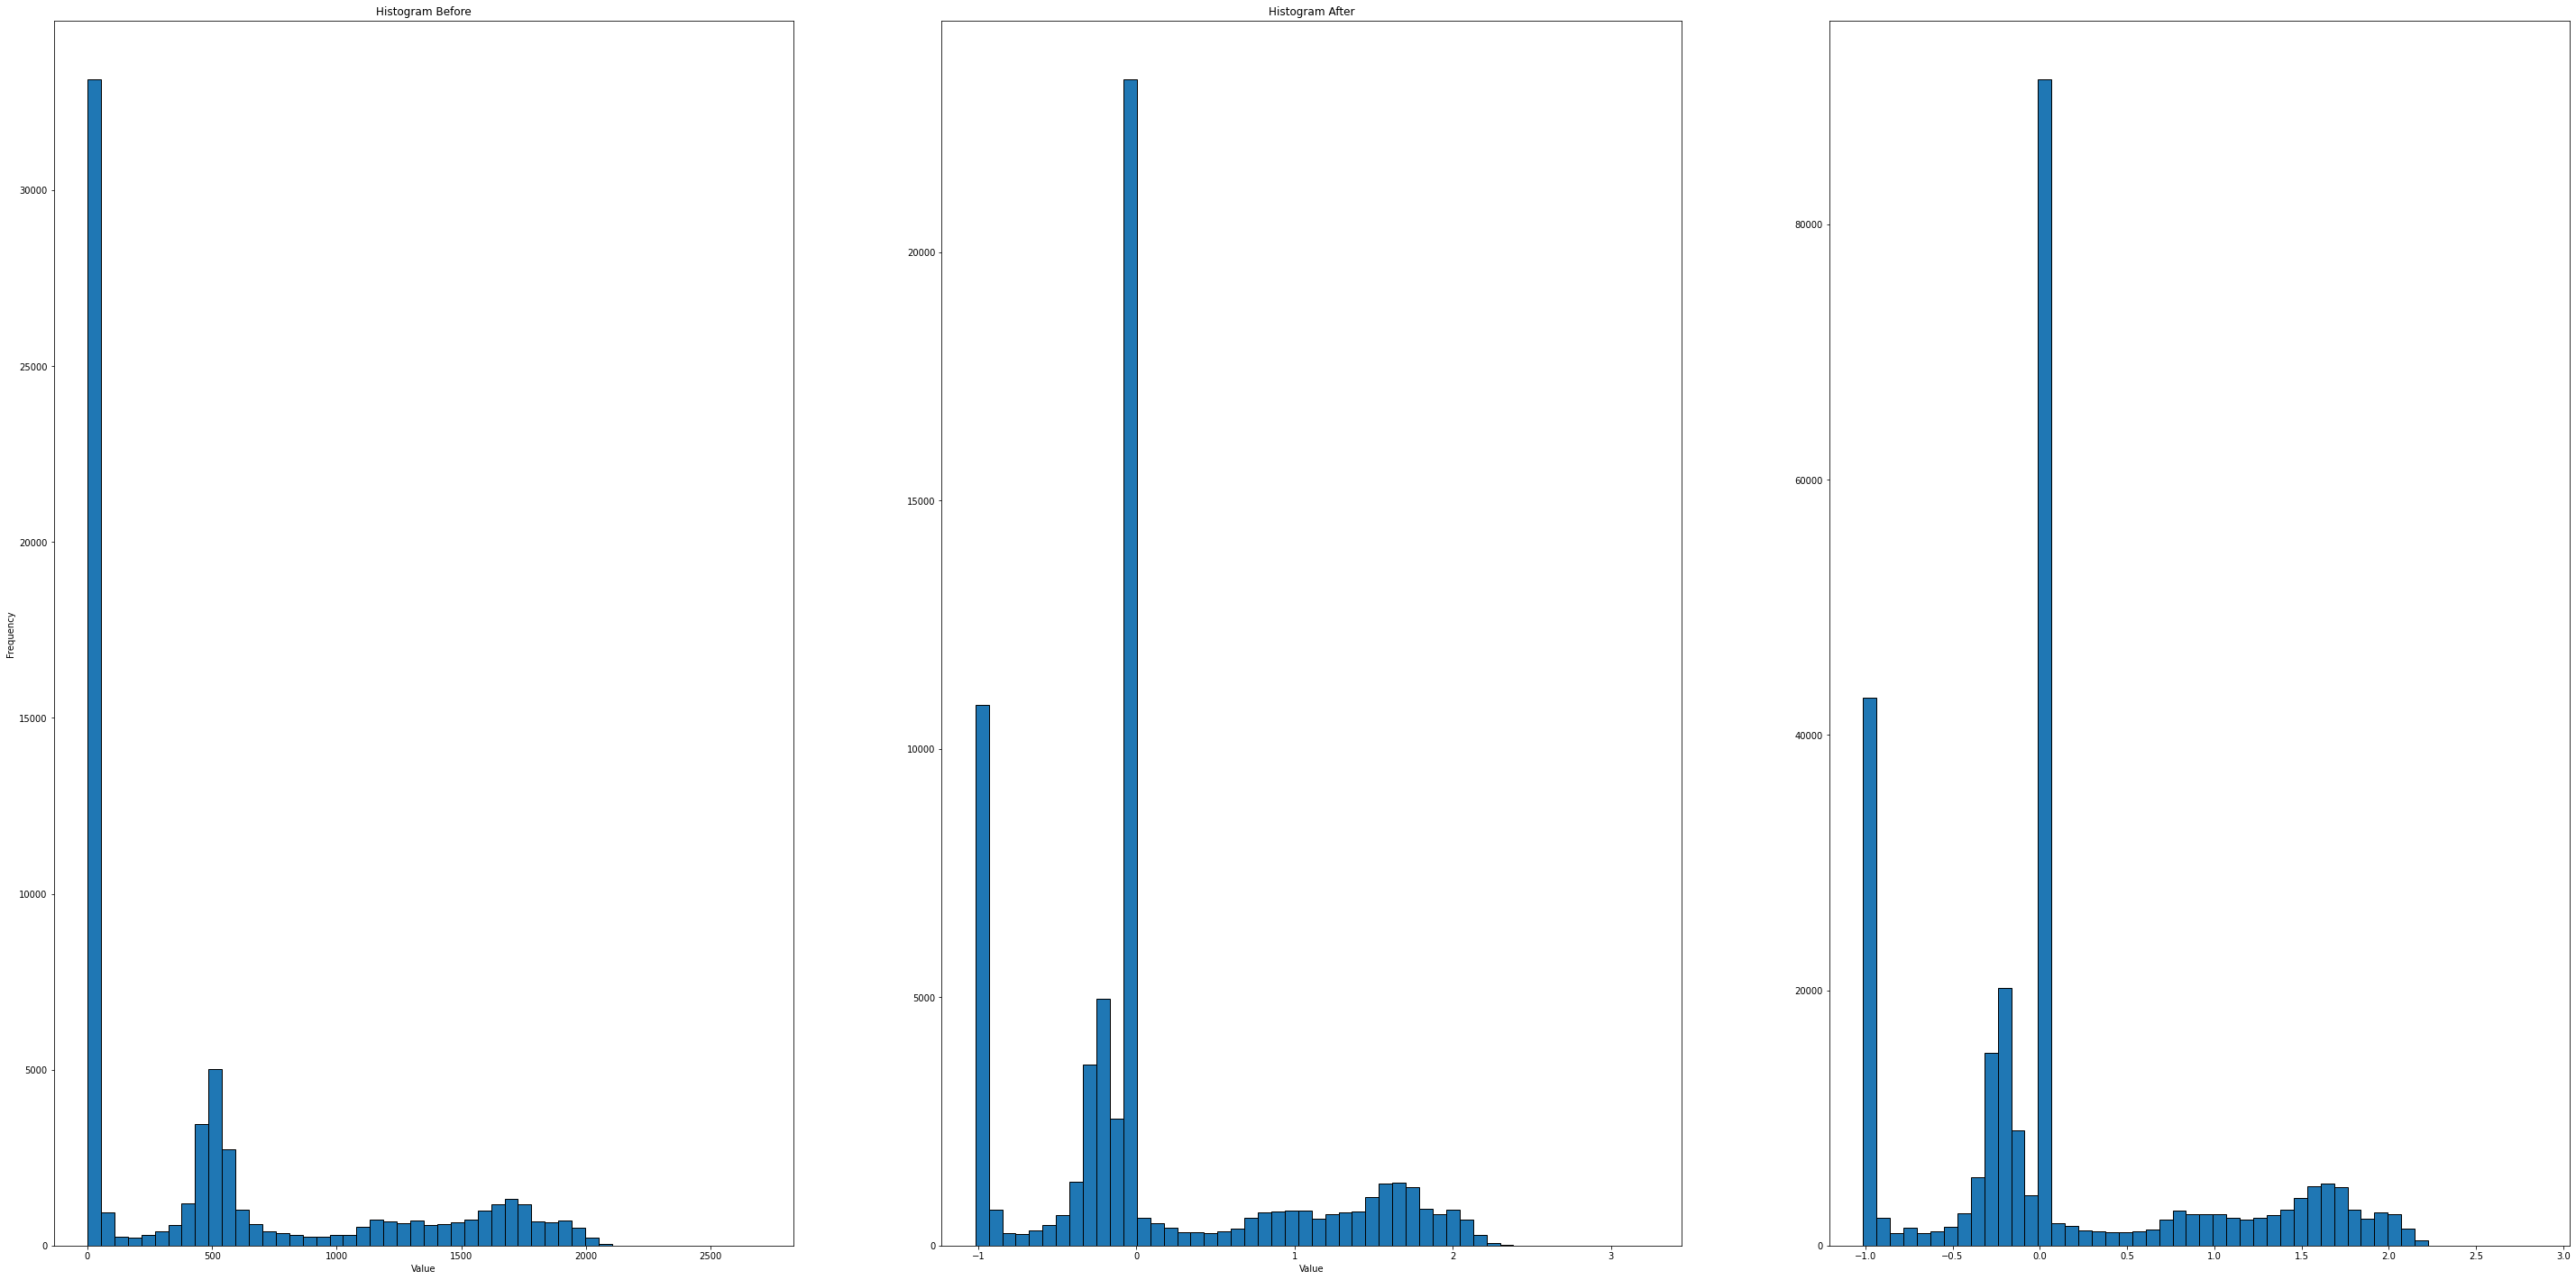

In [67]:
flatten_image = image[0,0,:,:,0].view(-1)
flatten_image_trial = image_trial[0,0,:,:,0].view(-1)
flatten_image_resize = image_resize[0,0,:,:,0].view(-1)


fig, axes = plt.subplots(1, 3, figsize=(50, 25))
axes[0].hist(flatten_image.numpy(), bins=50, edgecolor='k') 
axes[1].hist(flatten_image_trial.numpy(), bins=50, edgecolor='k') 
axes[2].hist(flatten_image_resize.numpy(), bins=50, edgecolor='k') 
axes[0].set_xlabel('Value'), axes[1].set_xlabel('Value')
axes[0].set_ylabel('Frequency'), axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram Before'), axes[1].set_title('Histogram After')
plt.show()